<a href="https://colab.research.google.com/github/rubycho/cv-notes/blob/master/CV03/CV03-2%20YOLO%20in%20Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YOLO in Tensorflow

In this file, we will use and inspect tensorflow implementation of YOLO v3.

The code we are using is: [zzh8829/yolov3-tf2](https://github.com/zzh8829/yolov3-tf2).

### First, Let's just try

In [1]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 387, done.
remote: Total 387 (delta 0), reused 0 (delta 0), pack-reused 387
Receiving objects: 100% (387/387), 4.22 MiB | 16.63 MiB/s, done.
Resolving deltas: 100% (226/226), done.
/content/yolov3-tf2


In [2]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py --weights ./data/yolov3.weights --output ./checkpoints/yolov3.tf

--2020-09-01 05:26:50--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M   603KB/s    in 6m 40s  

2020-09-01 05:33:31 (606 KB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2020-09-01 05:33:32.505912: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-01 05:33:35.094173: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-01 05:33:35.154252: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-09-01 05:33:35.154333: I tensorflow/stream_ex

In [3]:
!python detect.py --image ./data/meme.jpg

2020-09-01 05:33:43.723977: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-01 05:33:45.390992: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-01 05:33:45.394074: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-09-01 05:33:45.394117: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3597a3803766): /proc/driver/nvidia/version does not exist
2020-09-01 05:33:45.423180: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2300000000 Hz
2020-09-01 05:33:45.423430: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x22b2a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-09-01 05:33:45.423488: I tensorflow/com

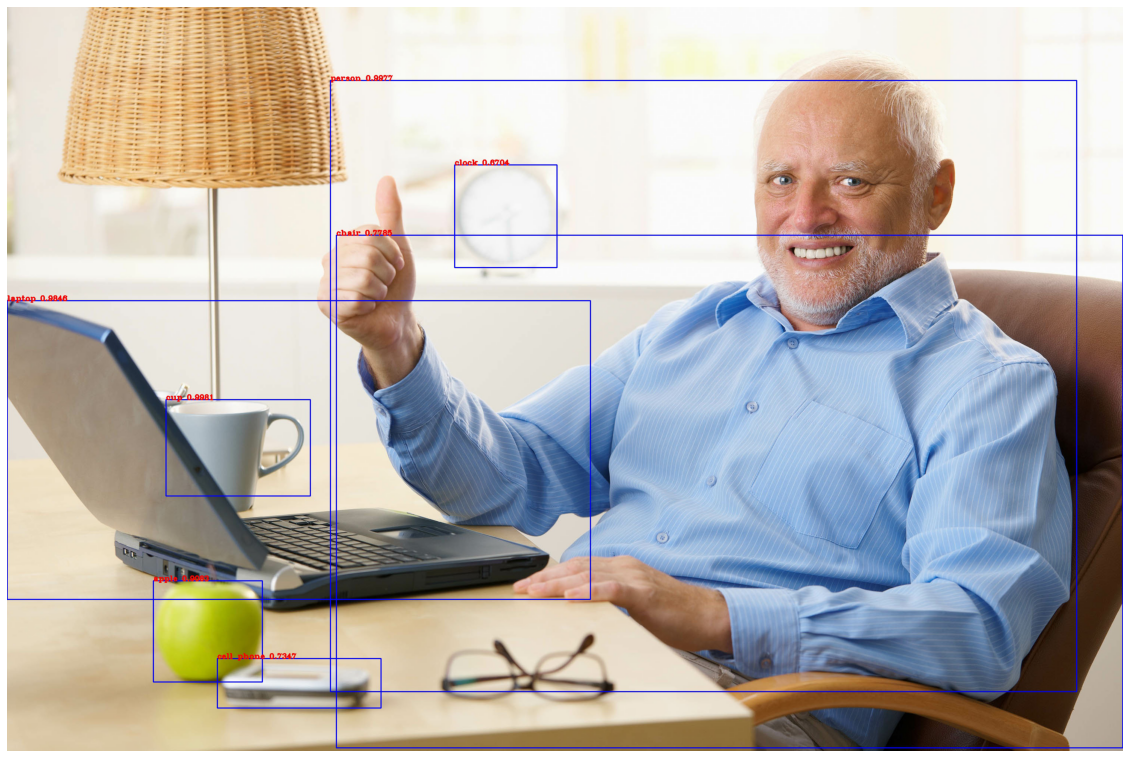

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mimg

img = mimg.imread('./output.jpg')

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)
plt.show()

## Second, Inspect, lightly

We will start with the `detect.py`. How does prediction works?

```python
...

def main(_argv):
  ...

  if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
  else:
    yolo = YoloV3(classes=FLAGS.num_classes)
  yolo.load_weights(FLAGS.weights).expect_partial()
  logging.info('weights loaded')

  class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
  logging.info('classes loaded')

  ...

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))

  logging.info('detections:')
  for i in range(nums[0]):
      logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                          np.array(scores[0][i]),
                                          np.array(boxes[0][i])))
  ...
```

The `YoloV3` function defines the YOLO architecture, returns a keras model,
and the method `load_weights()` loads pretrained yolo weights, from the file we converted.

And by calling yolo, we get predictions, such as boxes, scores, classes.

Before straightly going to implementation of `YoloV3`,
we will first check the darknet implementation.

Below is a code snippet from `models.py`.

```python
...

yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

...

def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x


def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x


def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x


def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)
...
```

You can find...
- anchor boxes
- DarknetConv Block
  - Conv2D + BatchNorm + LeakyReLU
- DarknetRes Block
  - DarknetConv (filters/2) + DarknetConv (filters) + Residual
- Darknet Block
  - DarknetConv Block (filters/2) + DarknetRes Block (filters)
- Darknet
  - DarknetConv Block, 32 filters
  - Darknet Block, 64 filters, 1 block
  - Darknet Block, 128 filters, 2 blocks
  - Darknet Block, 256 filters, 8 blocks
  - Darknet Block, 512 filters, 8 blocks
  - Darknet Block, 1024 filters, 4 blocks

Compare with the table in the paper:

![](https://github.com/rubycho/cv-notes/blob/master/CV03/darknet-53.png?raw=true)


Cont. next, `YoloConv` and `YoloOutput` appears.

`YoloConv` will be used to create skip connection, and `YoloOutput` to make appropriate YOLO output.

Notice that YOLO output has (# of anchor boxes * (5 + # of classes)), which 5 is confidence score, h, w, x, y.

```python
...

def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

...

def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output
...
```

Cont. 

`yolo_boxes` will process the predictions to easily access the box results.

`yolo_nms` will merge yolo outputs, do non max suppression with iou.

```python
...

def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1:3]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size[1]), tf.range(grid_size[0]))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box


def yolo_nms(outputs, anchors, masks, classes):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=FLAGS.yolo_max_boxes,
        max_total_size=FLAGS.yolo_max_boxes,
        iou_threshold=FLAGS.yolo_iou_threshold,
        score_threshold=FLAGS.yolo_score_threshold
    )

    return boxes, scores, classes, valid_detections
...
```

Finally, YOLO model is defined.

For YOLO architecture image, check this [link](https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b).

```python
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels], name='input')

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')
...
```

Last point, below is the loss implementation.

it calculates four losses: xy_loss, wh_loss, obj_loss, class_loss.

- xy_loss, wh_loss is calculated with square error.
- obj_loss is calculated with binary cross entropy.
- class_loss is calculated with sparse categorical cross entropy.

Though the paper suggested that they are not using softmax anymore, due to mutual exclusion assumption, so there is a TODO comment on calculating class_loss.

```python
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
      
        ...

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss
```

In the next file CV03-3, I will try to change the classes, and re-train it for specific purpose.